In [1]:
from time import sleep
from datetime import datetime
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import os
import pickle
import ast
import shap
import matplotlib.pyplot as plt
from joblib import dump, load
%matplotlib inline

In [2]:
df = pd.read_csv("../serv_rec_full_nprint_10pkts.csv")

In [3]:
df['filename'] = df['filename'].str.extract(r'\.pcap_(\d+\.\d+\.\d+\.\d+)')
df['ip_label'] = df['filename'].str.extract(r'^(\d+\.\d+)')
df['ip_label'] = df['ip_label'].astype('category').cat.codes
df.drop('filename', axis=1, inplace=True)
df

,pkt_0_ipv4_tos_0,pkt_0_ipv4_tos_1,pkt_0_ipv4_tos_2,pkt_0_ipv4_tos_3,pkt_0_ipv4_tos_4,pkt_0_ipv4_tos_5,pkt_0_ipv4_tos_6,pkt_0_ipv4_tl_5,pkt_0_ipv4_tl_6,pkt_0_ipv4_tl_7,...,pkt_9_udp_cksum_8,pkt_9_udp_cksum_9,pkt_9_udp_cksum_10,pkt_9_udp_cksum_11,pkt_9_udp_cksum_12,pkt_9_udp_cksum_13,pkt_9_udp_cksum_14,pkt_9_udp_cksum_15,Label,ip_label
0,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,twitch,46
1,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,twitch,88
2,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,twitch,46
3,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,twitch,88
4,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,twitch,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58084,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,zoom,88
58085,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,zoom,88
58086,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,zoom,88
58087,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,-1,-1,zoom,88


In [4]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_X_train = df_train.iloc[:, :-2]
df_Y_train = df_train.iloc[:, -2:]
df_X_test = df_test.iloc[:, :-2]
df_Y_test = df_test.iloc[:, -2:]

In [11]:
source_model = RandomForestClassifier(random_state=42)
source_model.fit(df_X_train, df_Y_train.iloc[:, 0].to_numpy())
# source_model_fi = source_model.feature_importances_

RandomForestClassifier(random_state=42)

In [12]:
threat_model = RandomForestClassifier(random_state=42)
threat_model.fit(df_X_train, df_Y_train.iloc[:, 1].to_numpy())
# threat_model_fi = threat_model.feature_importances_

RandomForestClassifier(random_state=42)

In [5]:
source_model = load('../serv_rec_full_nprint_10pkts_source_model.joblib')
threat_model = load('../serv_rec_full_nprint_10pkts_threat_model.joblib')

In [6]:
threat_pred = threat_model.predict(df_X_test)
act_pred = source_model.predict(df_X_test)

threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier

base_ident = threat_score
base_acc = act_score

base_acc, base_ident

(0.9558443794112584, 0.9166810122224135)

In [7]:
from joblib import dump, load
source_model_fi = load('../serv_rec_full_nprint_10pkts_source_model_fi.joblib')
threat_model_fi = load('../serv_rec_full_nprint_10pkts_threat_model_fi.joblib')

In [8]:
def compute_relative_effectiveness(ident, acc, base_ident, base_acc):
    numerator = ident - base_ident
    denominator = acc - base_acc
    if denominator == 0:
        return np.nan  # Avoid division by zero
    return np.log(numerator / denominator)

def plot_both_accuracies(score_list, legend_name):
    releff_list = [
        compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
        for row in score_list
    ]
        
    plt.figure(figsize=(10, 6))

    plt.plot(score_list[:, 0], releff_list, 'ro', label=legend_name)
#     plt.scatter(1-score_list[:, 2], score_list[:, 1])

    plt.title(f'# features vs. Relative Effectiveness')
    plt.xlabel('Number of features')
    plt.ylabel('Relative Effectiveness')
    # plt.ylim(0, 1.1)
    # plt.xlim(0, 1.1)

    # Adding a legend
    plt.legend()

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig(f'{legend_name}.png')
    plt.show()

In [9]:
df_X_train.shape

(46471, 3285)

In [10]:
df_Y_train.shape

(46471, 2)

In [11]:
df_X_test.shape

(11618, 3285)

In [12]:
df_Y_train

,Label,ip_label
28587,meet,42
1976,netflix,292
29835,meet,114
29930,meet,88
6235,twitch,88
...,...,...
54343,zoom,88
38158,teams,88
860,netflix,314
15795,netflix,88


In [22]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.datasets import load_iris
from scipy.stats import entropy
import numpy as np

# Compute mutual information for utility score
utility_scores = mutual_info_classif(df_X_train.to_numpy(), df_Y_train.iloc[:, 0].to_numpy())
print("Utility Scores (Mutual Information):", utility_scores)

# Function to compute the entropy of a feature
def compute_feature_entropy(feature):
    p, _ = np.histogram(feature, bins=10, density=True)
    p = p[p > 0]  # Remove zero entries to avoid log(0) issues
    return entropy(p)

# Function to compute privacy scores
def compute_privacy_scores(X):
    privacy_scores = []
    original_entropies = [compute_feature_entropy(X[:, i]) for i in range(X.shape[1])]
    total_original_entropy = sum(original_entropies)

    for i in range(X.shape[1]):
        # Compute the entropy of the dataset without the i-th feature
        sanitized_entropies = original_entropies[:i] + original_entropies[i+1:]
        total_sanitized_entropy = sum(sanitized_entropies)
        # Privacy score is the decrease in entropy
        privacy_score = total_original_entropy - total_sanitized_entropy
        privacy_scores.append(privacy_score)
    return privacy_scores

# Compute privacy scores
privacy_scores = compute_privacy_scores(df_X_train.to_numpy())
print("Privacy Scores (Entropy-Based):", privacy_scores)


# Normalize scores for combining
utility_scores_normalized = np.array(utility_scores) / np.max(utility_scores)
privacy_scores_normalized = np.array(privacy_scores) / np.max(privacy_scores)

# Combine utility and privacy scores to compute trade-off scores
def trade_off_score(utility_scores, privacy_scores):
    return [(u + p) / 2 for u, p in zip(utility_scores_normalized, privacy_scores_normalized)]

# Compute trade-off scores
trade_off_scores = trade_off_score(utility_scores, privacy_scores)
print("Trade-Off Scores:", trade_off_scores)


Utility Scores (Mutual Information): [0.03835952 0.00244939 0.0267657  ... 0.06782052 0.06895555 0.06832293]
Privacy Scores (Entropy-Based): [0.18475549605273045, 0.033811370409239316, 0.1368207444302243, 0.013357932411508955, 0.04326892322205822, 0.0027437167418611352, 0.007237963629904698, 0.27699569497826815, 0.06494000119027987, 0.30092226109991316, 0.3256924786583113, 0.6251920716631503, 0.5626245593384738, 0.6541873576902617, 0.6831655682672135, 0.6486392613373937, 0.3676737717019023, 0.3387608699372322, 0.6429276383041724, 0.6509839872805969, 0.6492544926759365, 0.6481121277683997, 0.6504072388479472, 0.649345739515411, 0.6487180511076076, 0.6519739966201996, 0.6487574185880476, 0.650522916043883, 0.6489932399003919, 0.6491109040448464, 0.64931967912662, 0.6504458161152797, 0.6490324795386186, 0.6548583906974272, 0.5106043416976718, 0.5345977721972304, 0.5345977721972304, 0.6930102569090195, 0.6931471784760106, 0.692643375003172, 0.6930102569090195, 0.6924125987461593, 0.6928634

In [50]:
utility_scores = load('../utility_scores.joblib')
privacy_scores = load('../privacy_scores.joblib')
trade_off_scores = load('../trade_off_scores.joblib')

In [52]:
np.argsort(utility_scores)[-10:]

array([ 242,  240,  168, 1655,  172, 1999,  990, 1325,  659,  331])

In [11]:
# Function to remove features with the lowest n scores
def remove_lowest_features(X, scores, n):
    # Get the indices of the features sorted by score
    sorted_indices = np.argsort(scores)
    # Get the indices of the features to remove
    indices_to_remove = sorted_indices[:n]
    # Remove the features from X
    X_modified = np.delete(X, indices_to_remove, axis=1)
    return X_modified


In [ ]:
# Privacy-utility score
score_list = []
from tqdm import tqdm
import multiprocessing as mp
import warnings

def compute_score(n_to_remove):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")

        opt_df_X_train = remove_lowest_features(df_X_train.to_numpy(), trade_off_scores, n_to_remove)
        opt_df_X_test = remove_lowest_features(df_X_test.to_numpy(), trade_off_scores, n_to_remove)

        rfc_act = RandomForestClassifier(random_state=42)
        rfc_act.fit(opt_df_X_train, df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier(random_state=42)
        rfc_threat.fit(opt_df_X_train, df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(opt_df_X_test)
        act_pred = rfc_act.predict(opt_df_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred)

        return [opt_df_X_train.shape[1], act_score, threat_score]

num_workers = mp.cpu_count() // 2  # Use all but one CPU core
n_values = range(1, len(trade_off_scores))

with mp.Pool(processes=num_workers) as pool:
    score_list = list(tqdm(pool.imap(compute_score, n_values), total=len(n_values)))

np.savetxt('serv_rec_full_nprint_10pkts-privacy-utility-parallel.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Privacy-utility')

 49%|████████████████████████████████████▉                                      | 1617/3284 [8:55:11<6:12:16, 13.40s/it]

/tmp/ipykernel_1099573/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)
/tmp/ipykernel_1099573/1236790252.py:6: RuntimeWarning: divide by zero encountered in log
  return np.log(numerator / denominator)


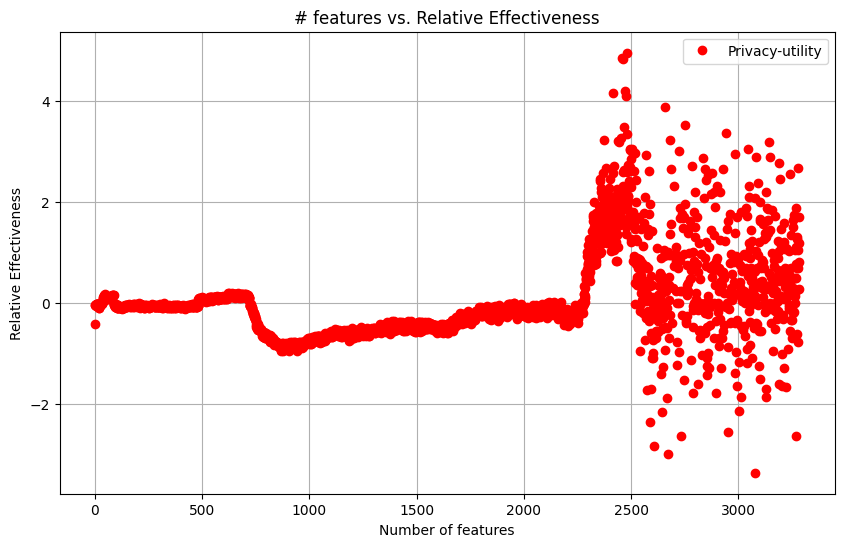

In [10]:
score_list = np.loadtxt('serv_rec_full_nprint_10pkts-privacy-utility-parallel.csv', delimiter=",")
plot_both_accuracies(np.array(score_list), 'Privacy-utility')

In [ ]:
# Privacy score
score_list = []
from tqdm import tqdm
import warnings
import multiprocessing as mp

def compute_score(n_to_remove):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")

        opt_df_X_train = remove_lowest_features(df_X_train.to_numpy(), privacy_scores, n_to_remove)
        opt_df_X_test = remove_lowest_features(df_X_test.to_numpy(), privacy_scores, n_to_remove)

        rfc_act = RandomForestClassifier(random_state=42)
        rfc_act.fit(opt_df_X_train, df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier(random_state=42)
        rfc_threat.fit(opt_df_X_train, df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(opt_df_X_test)
        act_pred = rfc_act.predict(opt_df_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred)

        return [opt_df_X_train.shape[1], act_score, threat_score]

num_workers = mp.cpu_count() // 3  # Use all but one CPU core
n_values = range(1, len(privacy_scores))

with mp.Pool(processes=num_workers) as pool:
    score_list = list(tqdm(pool.imap(compute_score, n_values), total=len(n_values)))

np.savetxt(f'serv_rec_full_nprint_10pkts-privacy-score.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Privacy score')

 26%|███████████████████▋                                                       | 862/3284 [7:04:47<14:45:37, 21.94s/it]

In [ ]:
# Feature utility score
score_list = []
from tqdm import tqdm
import warnings
import multiprocessing as mp

def compute_score(n_to_remove):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")

        opt_df_X_train = remove_lowest_features(df_X_train.to_numpy(), utility_scores, n_to_remove)
        opt_df_X_test = remove_lowest_features(df_X_test.to_numpy(), utility_scores, n_to_remove)

        rfc_act = RandomForestClassifier(random_state=42)
        rfc_act.fit(opt_df_X_train, df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier(random_state=42)
        rfc_threat.fit(opt_df_X_train, df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(opt_df_X_test)
        act_pred = rfc_act.predict(opt_df_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred)

        return [opt_df_X_train.shape[1], act_score, threat_score]

num_workers = mp.cpu_count() // 3  # Use all but one CPU core
n_values = range(1, len(utility_scores))

with mp.Pool(processes=num_workers) as pool:
    score_list = list(tqdm(pool.imap(compute_score, n_values), total=len(n_values)))

np.savetxt(f'serv_rec_full_nprint_10pkts-utility-score.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Utility score')

In [11]:
from sklearn.feature_extraction import FeatureHasher

def feature_hashing(df, n_features):
    # Convert DataFrame to a list of dictionaries
    data_dict = df.to_dict(orient='records')

    # Initialize FeatureHasher
    hasher = FeatureHasher(n_features=n_features, input_type='dict')

    # Transform data
    hashed_features = hasher.transform(data_dict).toarray()

    # Convert hashed features to DataFrame if needed
    hashed_df = pd.DataFrame(hashed_features)
    return hashed_df

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

def pca_reduction(df, n_components):
    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df)
    
    # Initialize PCA
    pca = PCA(n_components=n_components)
    
    # Fit and transform the data
    pca_features = pca.fit_transform(scaled_features)
    
    # Convert PCA features to DataFrame
    pca_df = pd.DataFrame(pca_features)
    return pca_df


In [ ]:
# # Feature hashing
# from tqdm import tqdm
# import warnings
# import multiprocessing as mp

# def compute_feature_hashing_score(n_features):
#     with warnings.catch_warnings():
#         warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
#         hashed_X_train = feature_hashing(df_X_train, n_features)
#         hashed_X_test = feature_hashing(df_X_test, n_features)

#         rfc_act = RandomForestClassifier(random_state=42)
#         rfc_act.fit(hashed_X_train.to_numpy(), df_Y_train.iloc[:, 0].to_numpy())

#         rfc_threat = RandomForestClassifier(random_state=42)
#         rfc_threat.fit(hashed_X_train.to_numpy(), df_Y_train.iloc[:, 1].to_numpy())

#         threat_pred = rfc_threat.predict(hashed_X_test)
#         act_pred = rfc_act.predict(hashed_X_test)

#         threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
#         act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier

#         return [n_features, act_score, threat_score]

# num_workers = mp.cpu_count() // 2  # Use all but one CPU core
# n_values = range(1, df_X_train.shape[1], 100)

# with mp.Pool(processes=num_workers) as pool:
#     score_list = list(tqdm(pool.imap(compute_feature_hashing_score, n_values), total=len(n_values)))

# np.savetxt(f'feature_hashing.csv', np.array(score_list), delimiter=",")
# plot_both_accuracies(np.array(score_list), 'Feature hashing')

  0%|                                                                                            | 0/33 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 66/66 [4:21:30<00:00, 237.74s/it]


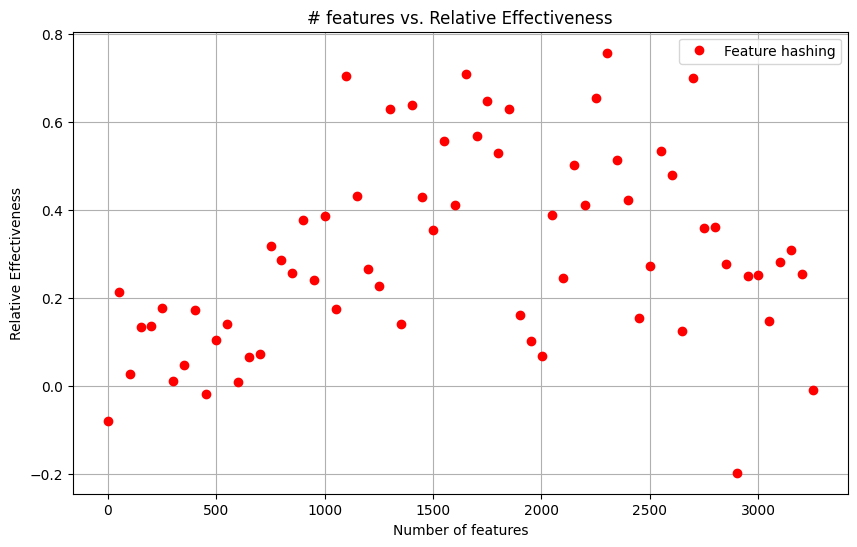

In [14]:
# Feature hashing
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for n_features in tqdm(range(1, df_X_train.shape[1], 50)):
        hashed_X_train = feature_hashing(df_X_train, n_features)
        hashed_X_test = feature_hashing(df_X_test, n_features)

        rfc_act = RandomForestClassifier(random_state=42)
        rfc_act.fit(hashed_X_train.to_numpy(), df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier(random_state=42)
        rfc_threat.fit(hashed_X_train.to_numpy(), df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(hashed_X_test)
        act_pred = rfc_act.predict(hashed_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([n_features, act_score, threat_score])

np.savetxt(f'serv_rec_full_nprint_10pkts-feature_hashing.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Feature hashing')

100%|█████████████████████████████████████████████████████████████████████████████| 110/110 [25:01:29<00:00, 818.99s/it]


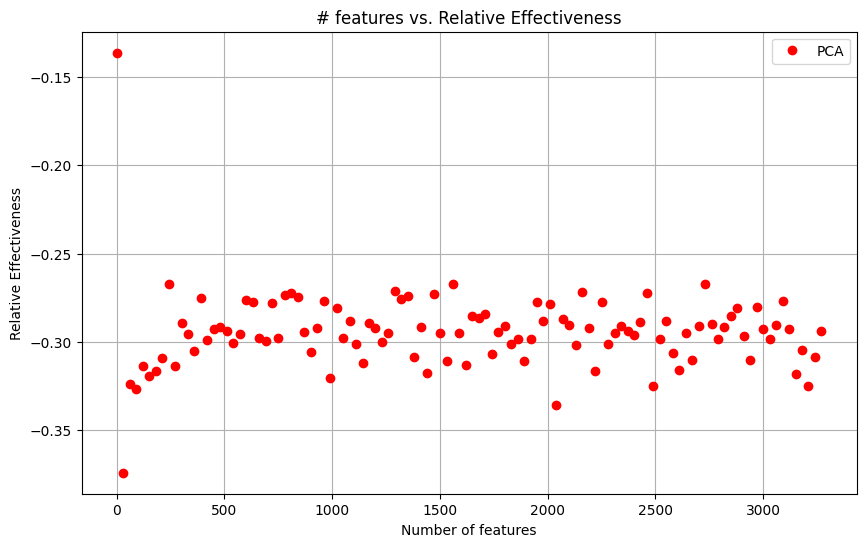

In [15]:
# PCA dimensionality reduction
from tqdm import tqdm
import warnings

import multiprocessing as mp

def compute_pca_score(n_features):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
        reduced_X_train = pca_reduction(df_X_train, n_features)
        reduced_X_test = pca_reduction(df_X_test, n_features)

        rfc_act = RandomForestClassifier(random_state=42)
        rfc_act.fit(reduced_X_train.to_numpy(), df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier(random_state=42)
        rfc_threat.fit(reduced_X_train.to_numpy(), df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(reduced_X_test)
        act_pred = rfc_act.predict(reduced_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier

        return [reduced_X_train.shape[1], act_score, threat_score]

num_workers = mp.cpu_count() // 3  # Use all but one CPU core
n_values = range(1, df_X_train.shape[1], 30)

with mp.Pool(processes=num_workers) as pool:
    score_list = list(tqdm(pool.imap(compute_pca_score, n_values), total=len(n_values)))

np.savetxt(f'serv_rec_full_nprint_10pkts-pca_reduction.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'PCA')

In [14]:
def add_laplace_noise(df, epsilon):
    # Define the scale of the Laplace noise
    scale = 1.0 / epsilon
    
    # Create a noise matrix with the same shape as the DataFrame
    noise = np.random.laplace(loc=0, scale=scale, size=df.shape)
    
    # Add the noise to the original DataFrame
    noisy_df = df + noise
    
    # Convert the result back to a DataFrame
    noisy_df = pd.DataFrame(noisy_df, columns=df.columns)
    return noisy_df

100%|████████████████████████████████████████████████████████████████████████████████| 9/9 [14:40:35<00:00, 5870.63s/it]


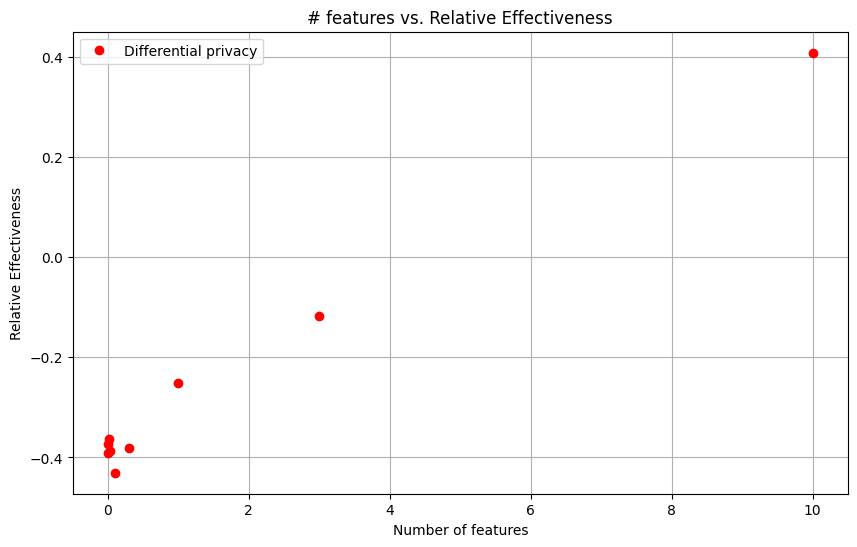

In [15]:
# Differential privacy: laplace noise
score_list = []
from tqdm import tqdm
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="y_pred contains classes not in y_true")
    for epsilon in tqdm([0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]):
        noisy_X_train = add_laplace_noise(df_X_train, epsilon)
        noisy_X_test = add_laplace_noise(df_X_test, epsilon)

        rfc_act = RandomForestClassifier(random_state=42)
        rfc_act.fit(noisy_X_train, df_Y_train.iloc[:, 0].to_numpy())

        rfc_threat = RandomForestClassifier(random_state=42)
        rfc_threat.fit(noisy_X_train, df_Y_train.iloc[:, 1].to_numpy())

        threat_pred = rfc_threat.predict(noisy_X_test)
        act_pred = rfc_act.predict(noisy_X_test)

        threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), threat_pred)  # Source IP re-id classifier (Threat)
        act_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred) # Network Intrusion classifier
        score_list.append([epsilon, act_score, threat_score])

np.savetxt(f'serv_rec_full_nprint_10pkts-differential_privacy.csv', np.array(score_list), delimiter=",")
plot_both_accuracies(np.array(score_list), 'Differential privacy')

In [29]:
def shap_feature_selection(df_X_train, df_Y_train, custom_text=''):
    rfc_act = RandomForestClassifier(random_state=42)
    rfc_act.fit(df_X_train.to_numpy(), df_Y_train.iloc[:, 0].to_numpy())

    rfc_threat = RandomForestClassifier(random_state=42)
    rfc_threat.fit(df_X_train.to_numpy(), df_Y_train.iloc[:, 1].to_numpy())

    if os.path.exists(f'shap_values_act_{custom_text}.joblib'):
        shap_values_act = load(f'shap_values_act_{custom_text}.joblib')
    else:
        explainer_act = shap.Explainer(rfc_act, feature_names=df_X_train.columns.tolist())
        shap_values_act = explainer_act(df_X_train)
        dump(shap_values_act, f'shap_values_act_{custom_text}.joblib')
    y_value = np.mean(np.amax(np.absolute(shap_values_act.values), axis=2), axis=0)

    if os.path.exists(f'shap_values_threat_{custom_text}.joblib'):
        shap_values_threat = load(f'shap_values_threat_{custom_text}.joblib')
    else:
        explainer_threat = shap.Explainer(rfc_threat, feature_names=df_X_train.columns.tolist())
        shap_values_threat = explainer_threat(df_X_train)
        dump(shap_values_threat, f'shap_values_threat_{custom_text}.joblib')
    x_src_ip = np.mean(np.amax(np.absolute(shap_values_threat.values), axis=2), axis=0)

    score_list_both = []
    score_list_threat = []
    score_list_source = []

    for perc in [3,5,7,9,10,20,30,40,50,60,70,80,90,100]:
        len_feat_i_threat, threat_score_i_threat, y_score_i_threat = get_accuracy_for_threat_model(perc, df_X_train, df_Y_train, x_src_ip, y_value)
        score_list_threat.append([len_feat_i_threat, y_score_i_threat, threat_score_i_threat])

        len_feat_i_source, threat_score_i_source, y_score_i_source = get_accuracy_for_source_model(perc, df_X_train, df_Y_train, x_src_ip, y_value)
        score_list_source.append([len_feat_i_source, y_score_i_source, threat_score_i_source])
        
        len_feat_i, threat_score_i, y_score_i = get_accuracy_for_both_models(perc, df_X_train, df_Y_train, x_src_ip, y_value)
        score_list_both.append([len_feat_i, y_score_i, threat_score_i])

    np.savetxt(f'shap_{custom_text}.score_list_both.csv', np.array(score_list_both), delimiter=",")
    np.savetxt(f'shap_{custom_text}.score_list_source.csv', np.array(score_list_source), delimiter=",")
    np.savetxt(f'shap_{custom_text}.score_list_threat.csv', np.array(score_list_threat), delimiter=",")

    score_lists = [np.array(score_list_both), np.array(score_list_source), np.array(score_list_threat)]
    legend_lists = ['SHAP greedy on both', 'SHAP greedy on source', 'SHAP greedy on threat']
    plot_multiple_accuracies(score_lists, legend_lists)

In [78]:
# 2024-06-24: fix nan issue with np.percentile
def get_accuracy_for_both_models(perc, df_X_train, df_Y_train, x_src_ip, y_value):
    ratio = x_src_ip / y_value
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, perc)
    if perc == 100:
        threshold = np.inf
    feat_idx = np.where(x_src_ip / y_value < threshold)[0]
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    new_train = df_X_train.iloc[:, feat_idx].to_numpy()
    new_test = df_X_test.iloc[:, feat_idx].to_numpy()
    rfc_src_ip_noise = RandomForestClassifier(random_state=42)
#     rfc_src_ip_noise = SVC(probability=True)
    rfc_src_ip_noise.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())
#     dump(rfc_src_ip, f'rfc_src_ip_by_subnet_noise_perc_{perc}.joblib')

    rfc_label = RandomForestClassifier(random_state=42)
#     rfc_label = SVC(probability=True)
    rfc_label.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())
#     dump(rfc_label, f'rfc_label_by_subnet_noise_perc_{perc}_by_src_ip.joblib')
    
    ip_pred_new = rfc_src_ip_noise.predict(new_test)
    act_pred_new = rfc_label.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier
    
    # Compute class-wise accuracies and confidence intervals
#     threat_class_accuracies, threat_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_class_accuracies, source_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    # Compute overall confidence intervals
#     threat_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    
#     cdf_classwise_accuracy(perc, df_Y_test, ip_pred_new, act_pred_new)
    return len(feat_idx), threat_score, y_score


def get_accuracy_for_threat_model(perc, df_X_train, df_Y_train, x_src_ip, y_value):
    ratio = x_src_ip
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(ratio, perc)
    
    if perc == 100:
        threshold = np.inf
    if threshold == 0:
        threshold = min(ratio[ratio != 0])
    print(threshold)
    feat_idx = np.where(x_src_ip < threshold)[0]
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    new_train = df_X_train.iloc[:, feat_idx].to_numpy()
    new_test = df_X_test.iloc[:, feat_idx].to_numpy()
    rfc_src_ip_noise = RandomForestClassifier(random_state=42)
#     rfc_src_ip_noise = SVC(probability=True)
    rfc_src_ip_noise.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())
#     dump(rfc_src_ip, f'rfc_src_ip_by_subnet_noise_perc_{perc}.joblib')

    rfc_label = RandomForestClassifier(random_state=42)
#     rfc_label = SVC(probability=True)
    rfc_label.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())
#     dump(rfc_label, f'rfc_label_by_subnet_noise_perc_{perc}_by_src_ip.joblib')
    
    ip_pred_new = rfc_src_ip_noise.predict(new_test)
    act_pred_new = rfc_label.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier

    # Compute class-wise accuracies and confidence intervals
#     threat_class_accuracies, threat_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_class_accuracies, source_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    # Compute overall confidence intervals
#     threat_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    
#     cdf_classwise_accuracy(perc, df_Y_test, ip_pred_new, act_pred_new)
    return len(feat_idx), threat_score, y_score


def get_accuracy_for_source_model(perc, df_X_train, df_Y_train, x_src_ip, y_value):
    ratio = y_value
    ratio = ratio[~np.isnan(ratio)]
    max_finite = np.max(ratio[np.isfinite(ratio)])
    ratio[ratio == np.inf] = max_finite
    threshold = np.percentile(-ratio, perc)
    if perc == 100:
        threshold = np.inf
    if threshold == 0:
        threshold = min(ratio[ratio != 0])
    print(threshold)
    feat_idx = np.where(y_value > -threshold)[0]
    print(f"Percentile of features to keep: {perc}; Number of features to keep: {len(feat_idx)}; Ratio Threshold: {threshold}")
    new_train = df_X_train.iloc[:, feat_idx].to_numpy()
    new_test = df_X_test.iloc[:, feat_idx].to_numpy()
    rfc_src_ip_noise = RandomForestClassifier(random_state=42)
#     rfc_src_ip_noise = SVC(probability=True)
    rfc_src_ip_noise.fit(new_train, df_Y_train.iloc[:, 1].to_numpy())
#     dump(rfc_src_ip, f'rfc_src_ip_by_subnet_noise_perc_{perc}.joblib')

    rfc_label = RandomForestClassifier(random_state=42)
#     rfc_label = SVC(probability=True)
    rfc_label.fit(new_train, df_Y_train.iloc[:, 0].to_numpy())
#     dump(rfc_label, f'rfc_label_by_subnet_noise_perc_{perc}_by_src_ip.joblib')
    
    ip_pred_new = rfc_src_ip_noise.predict(new_test)
    act_pred_new = rfc_label.predict(new_test)
    
    threat_score = accuracy_score(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)  # Source IP re-id classifier (Threat)
    y_score = accuracy_score(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new) # Network Intrusion classifier
    
    # Compute class-wise accuracies and confidence intervals
#     threat_class_accuracies, threat_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_class_accuracies, source_confidence_intervals = compute_class_accuracies_and_confidence(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    # Compute overall confidence intervals
#     threat_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 1].to_numpy(), ip_pred_new)
#     source_conf_interval = compute_overall_confidence_interval(df_Y_test.iloc[:, 0].to_numpy(), act_pred_new)
    
    
#     cdf_classwise_accuracy(perc, df_Y_test, ip_pred_new, act_pred_new)
    return len(feat_idx), threat_score, y_score




0.000345788089309929
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 0.000345788089309929
-0.0259483046287807
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.0259483046287807


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.6883489342947032
0.000345788089309929
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 0.000345788089309929
-0.021055770686732467
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.021055770686732467


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.7481849663147832


y_pred contains classes not in y_true


0.000345788089309929
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 0.000345788089309929
-0.019566215999852567
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.019566215999852567


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.7758001652319662


y_pred contains classes not in y_true


0.000345788089309929
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 0.000345788089309929
-0.018518796471866567
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.018518796471866567


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.8190102914741936


y_pred contains classes not in y_true


0.000345788089309929
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 0.000345788089309929
-0.018298797875781588
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.018298797875781588


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.8279857583544307


y_pred contains classes not in y_true


0.0010261120077065902
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 0.0010261120077065902
-0.011480830745940428
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.011480830745940428


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 1.1299082506219014


y_pred contains classes not in y_true


0.00234510331867148
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 0.00234510331867148
-0.007032418034195749
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.007032418034195749


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 1.4715875073910558


y_pred contains classes not in y_true


0.006094515266366578
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 0.006094515266366578


y_pred contains classes not in y_true


-0.0032641488662918327
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.0032641488662918327


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 1.8471159210524322


y_pred contains classes not in y_true


0.009694196555117185
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 0.009694196555117185


y_pred contains classes not in y_true


-0.0026320228393253977
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0026320228393253977


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 2.1789045807523104


y_pred contains classes not in y_true


0.012401847680302336
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 0.012401847680302336


y_pred contains classes not in y_true


-0.0018981602316618072
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0018981602316618072


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 3.2498742934135336


y_pred contains classes not in y_true


0.015368207961781498
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.015368207961781498


y_pred contains classes not in y_true


-0.001045037868649539
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.001045037868649539


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 4.6614072191597495


y_pred contains classes not in y_true


0.019439058798587476
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.019439058798587476


y_pred contains classes not in y_true


4.010057997261147e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 5.357702305870627


y_pred contains classes not in y_true


0.023125880833344145
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.023125880833344145


y_pred contains classes not in y_true


4.010057997261147e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 4.010057997261147e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 15.902666224148232


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 58; Ratio Threshold: inf


y_pred contains classes not in y_true


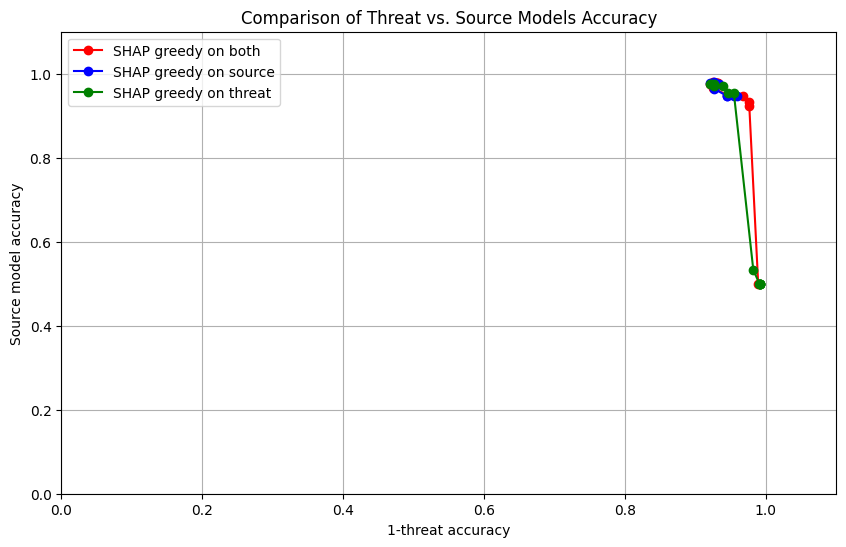

In [95]:
shap_feature_selection(df_X_train, df_Y_train, custom_text='train size:1')

Training set size: 0.001
0.0019999999999999996
Percentile of features to keep: 3; Number of features to keep: 24; Ratio Threshold: 0.0019999999999999996


y_pred contains classes not in y_true


-0.020020000000000003
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.020020000000000003


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.22461445559271642


y_pred contains classes not in y_true


0.0019999999999999996
Percentile of features to keep: 5; Number of features to keep: 24; Ratio Threshold: 0.0019999999999999996


y_pred contains classes not in y_true


-0.01814
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.01814


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 3; Ratio Threshold: 0.23356586224233283


y_pred contains classes not in y_true


0.0019999999999999996
Percentile of features to keep: 7; Number of features to keep: 24; Ratio Threshold: 0.0019999999999999996


y_pred contains classes not in y_true


-0.015555999999999999
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.015555999999999999


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 4; Ratio Threshold: 0.298202614379085


y_pred contains classes not in y_true


0.0019999999999999996
Percentile of features to keep: 9; Number of features to keep: 24; Ratio Threshold: 0.0019999999999999996


y_pred contains classes not in y_true


-0.014972
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.014972


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 5; Ratio Threshold: 0.3623737373737374


y_pred contains classes not in y_true


0.0019999999999999996
Percentile of features to keep: 10; Number of features to keep: 24; Ratio Threshold: 0.0019999999999999996
-0.014679999999999999
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.014679999999999999


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 5; Ratio Threshold: 0.36363636363636365


y_pred contains classes not in y_true


0.0019999999999999996
Percentile of features to keep: 20; Number of features to keep: 24; Ratio Threshold: 0.0019999999999999996
-0.010400000000000001
Percentile of features to keep: 20; Number of features to keep: 14; Ratio Threshold: -0.010400000000000001


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 10; Ratio Threshold: 0.6532407407407407


y_pred contains classes not in y_true


0.0019999999999999996
Percentile of features to keep: 30; Number of features to keep: 24; Ratio Threshold: 0.0019999999999999996
-0.009600000000000001
Percentile of features to keep: 30; Number of features to keep: 21; Ratio Threshold: -0.009600000000000001


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 15; Ratio Threshold: 0.8972222222222223


y_pred contains classes not in y_true


0.0048000000000000004
Percentile of features to keep: 40; Number of features to keep: 29; Ratio Threshold: 0.0048000000000000004


y_pred contains classes not in y_true


-0.008400000000000001
Percentile of features to keep: 40; Number of features to keep: 29; Ratio Threshold: -0.008400000000000001


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 20; Ratio Threshold: 1.1597222222222223


y_pred contains classes not in y_true


0.007538888888888888
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 0.007538888888888888


y_pred contains classes not in y_true


-0.0048000000000000004
Percentile of features to keep: 50; Number of features to keep: 36; Ratio Threshold: -0.0048000000000000004


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 25; Ratio Threshold: 1.2864583333333333


y_pred contains classes not in y_true


0.008635555555555554
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 0.008635555555555554


y_pred contains classes not in y_true


0.004399999999999999
Percentile of features to keep: 60; Number of features to keep: 74; Ratio Threshold: 0.004399999999999999


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 30; Ratio Threshold: 1.6785714285714286


y_pred contains classes not in y_true


0.011919999999999998
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.011919999999999998


y_pred contains classes not in y_true


0.004399999999999999
Percentile of features to keep: 70; Number of features to keep: 74; Ratio Threshold: 0.004399999999999999


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 35; Ratio Threshold: 2.7076719576719572


y_pred contains classes not in y_true


0.015211111111111116
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.015211111111111116


y_pred contains classes not in y_true


0.004399999999999999
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 0.004399999999999999


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 40; Ratio Threshold: 3.7045454545454555


y_pred contains classes not in y_true


0.017710000000000004
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.017710000000000004


y_pred contains classes not in y_true


0.004399999999999999
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 0.004399999999999999


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 40; Ratio Threshold: 3.7045454545454555


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 41; Ratio Threshold: inf


y_pred contains classes not in y_true


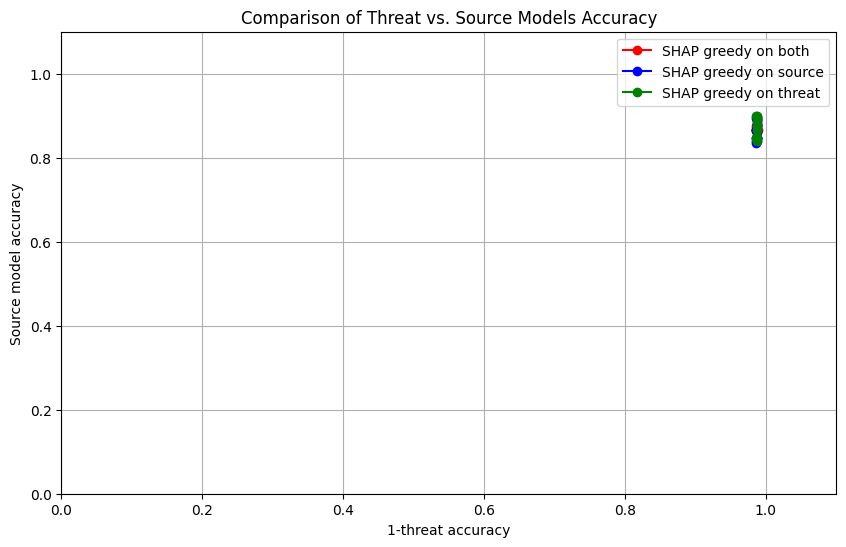

Training set size: 0.003
0.0009682539682539682
Percentile of features to keep: 3; Number of features to keep: 14; Ratio Threshold: 0.0009682539682539682
-0.02234346825396825
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.02234346825396825


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.2612285738033538


y_pred contains classes not in y_true


0.0009682539682539682
Percentile of features to keep: 5; Number of features to keep: 14; Ratio Threshold: 0.0009682539682539682
-0.017971327160493825
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.017971327160493825


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 3; Ratio Threshold: 0.5657540701717458


y_pred contains classes not in y_true


0.0009682539682539682
Percentile of features to keep: 7; Number of features to keep: 14; Ratio Threshold: 0.0009682539682539682
-0.015940045584045586
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.015940045584045586


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.6730710090253786


y_pred contains classes not in y_true


0.0009682539682539682
Percentile of features to keep: 9; Number of features to keep: 14; Ratio Threshold: 0.0009682539682539682
-0.01519495681170681
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.01519495681170681


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.7398805855480628


y_pred contains classes not in y_true


0.0009682539682539682
Percentile of features to keep: 10; Number of features to keep: 14; Ratio Threshold: 0.0009682539682539682
-0.014711460113960113
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.014711460113960113


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 6; Ratio Threshold: 0.7576877023201548


y_pred contains classes not in y_true


0.001053964886964887
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 0.001053964886964887
-0.008674939874939874
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.008674939874939874


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 12; Ratio Threshold: 1.199923300179289


y_pred contains classes not in y_true


0.004543047966436854
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 0.004543047966436854


y_pred contains classes not in y_true


-0.005508164335664336
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.005508164335664336


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 18; Ratio Threshold: 1.583876590507861


y_pred contains classes not in y_true


0.006269691388564406
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 0.006269691388564406


y_pred contains classes not in y_true


-0.004300722462722462
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.004300722462722462


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 24; Ratio Threshold: 1.8830295950682758


y_pred contains classes not in y_true


0.008346710032422995
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 0.008346710032422995


y_pred contains classes not in y_true


-0.0029236552028218694
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0029236552028218694


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 30; Ratio Threshold: 2.4269688233182514


y_pred contains classes not in y_true


0.009546964794327756
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 0.009546964794327756


y_pred contains classes not in y_true


-0.0023066666666666674
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0023066666666666674


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 36; Ratio Threshold: 3.3435558365540796


y_pred contains classes not in y_true


0.011781204131927743
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.011781204131927743


y_pred contains classes not in y_true


-0.0007150000000000044
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0007150000000000044


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 42; Ratio Threshold: 3.852459316785498


y_pred contains classes not in y_true


0.01445765311848645
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.01445765311848645


y_pred contains classes not in y_true


0.0007944444444444443
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 0.0007944444444444443


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 48; Ratio Threshold: 6.183503131000311


y_pred contains classes not in y_true


0.01935067584175084
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.01935067584175084


y_pred contains classes not in y_true


0.0007944444444444443
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 0.0007944444444444443


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 51; Ratio Threshold: 13.954929346747534


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 52; Ratio Threshold: inf


y_pred contains classes not in y_true


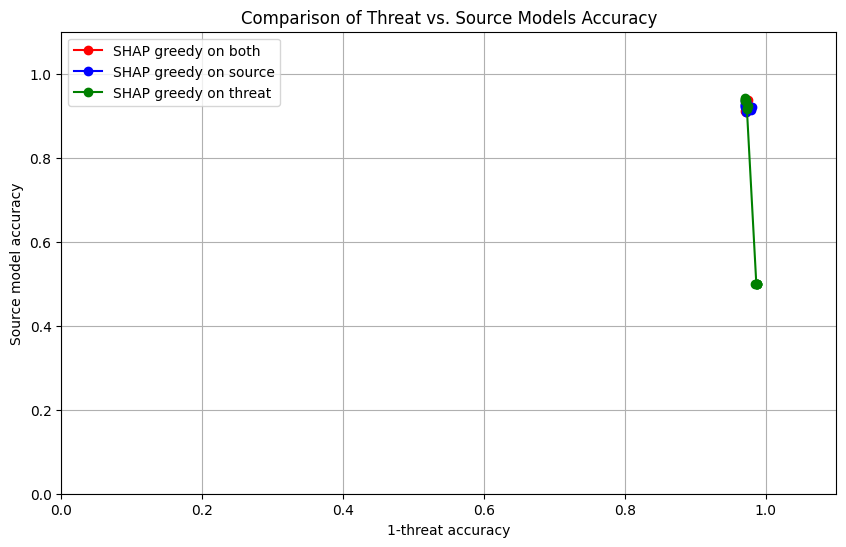

Training set size: 0.01
0.0011233224591742329
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 0.0011233224591742329
-0.01963877378869015
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.01963877378869015


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.7399979734432741


y_pred contains classes not in y_true


0.0011233224591742329
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 0.0011233224591742329
-0.01773607466701091
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.01773607466701091


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.7839373341133871


y_pred contains classes not in y_true


0.0011233224591742329
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 0.0011233224591742329
-0.015459269853519898
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.015459269853519898


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.8217586976524275


y_pred contains classes not in y_true


0.0011233224591742329
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 0.0011233224591742329
-0.013438279825780679
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.013438279825780679


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.9117444852473854


y_pred contains classes not in y_true


0.0011233224591742329
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 0.0011233224591742329
-0.013193583934094907
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.013193583934094907


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 1.0126176980103136


y_pred contains classes not in y_true


0.002322470921929598
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 0.002322470921929598
-0.006332670952975875
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.006332670952975875


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 1.5913308674689686


y_pred contains classes not in y_true


0.003128255913741892
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 0.003128255913741892
-0.004908766810441534
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.004908766810441534


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 1.8844808334448795


y_pred contains classes not in y_true


0.007059932823540161
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 0.007059932823540161
-0.003690557225688848
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.003690557225688848


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 2.137401652545342


y_pred contains classes not in y_true


0.008533107814486145
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 0.008533107814486145


y_pred contains classes not in y_true


-0.0027626636603744065
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0027626636603744065


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 2.860864532686786
0.010082638111184693
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 0.010082638111184693


y_pred contains classes not in y_true


-0.0018726723353443945
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0018726723353443945


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 3.2650793402965768


y_pred contains classes not in y_true


0.012455362972510087
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.012455362972510087


y_pred contains classes not in y_true


-0.0006837605371254774
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0006837605371254774


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 4.3786336347544985
0.01694781127661692
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.01694781127661692
0.0004796366407982261
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 0.0004796366407982261


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 6.876194488652042
0.023130314000099347
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.023130314000099347
0.0004796366407982261
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 0.0004796366407982261


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 52; Ratio Threshold: 12.430257639135009
inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf
inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 53; Ratio Threshold: inf


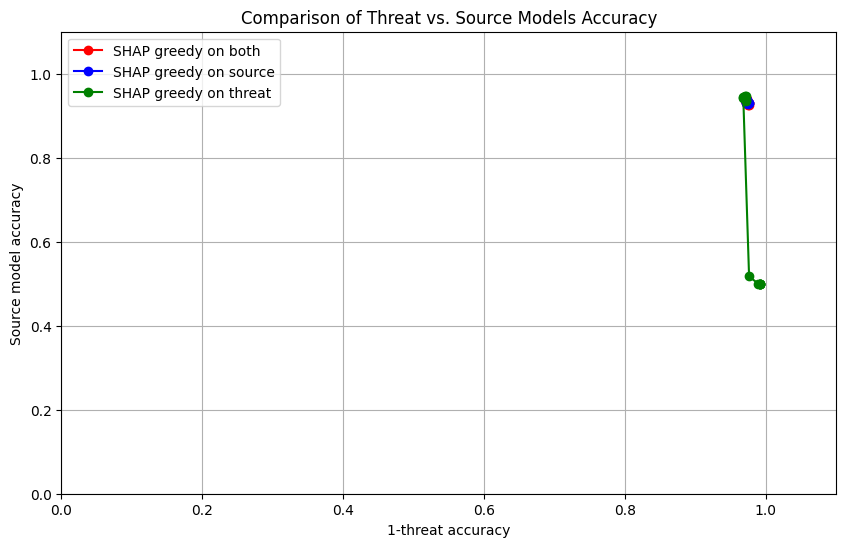

Training set size: 0.03
0.0006669333502607023
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 0.0006669333502607023
-0.025993414240646762
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.025993414240646762


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.8001856074395699


y_pred contains classes not in y_true


0.0006669333502607023
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 0.0006669333502607023
-0.023640848764364567
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.023640848764364567


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.8668257300877076


y_pred contains classes not in y_true


0.0006669333502607023
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 0.0006669333502607023
-0.02074050616724318
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.02074050616724318


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.8875958328143131


y_pred contains classes not in y_true


0.0006669333502607023
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 0.0006669333502607023
-0.018246229298013405
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.018246229298013405


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.9501379039128073


y_pred contains classes not in y_true


0.0006669333502607023
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 0.0006669333502607023
-0.017782152867527774
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.017782152867527774


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 1.0111893684965505


y_pred contains classes not in y_true


0.0010708272425673478
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 0.0010708272425673478


y_pred contains classes not in y_true


-0.00798475365229443
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.00798475365229443


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 1.3807702032817144


y_pred contains classes not in y_true


0.002216739954407778
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 0.002216739954407778
-0.004129521279659913
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.004129521279659913


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 1.725893614811256


y_pred contains classes not in y_true


0.006131819779500951
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 0.006131819779500951


y_pred contains classes not in y_true


-0.0029945644714795476
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.0029945644714795476


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 2.276850784244134


y_pred contains classes not in y_true


0.009268252634913442
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 0.009268252634913442


y_pred contains classes not in y_true


-0.0015405706737857887
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0015405706737857887


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 3.137206659158285


y_pred contains classes not in y_true


0.012995794447499041
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 0.012995794447499041


y_pred contains classes not in y_true


-0.0011385611931961635
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0011385611931961635


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 4.905387945323932


y_pred contains classes not in y_true


0.014662023094263786
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.014662023094263786


y_pred contains classes not in y_true


-0.00028177068177171936
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.00028177068177171936


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 8.474871324261747


y_pred contains classes not in y_true


0.017914370811312766
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.017914370811312766


y_pred contains classes not in y_true


9.3555356673401e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 9.3555356673401e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 12.59132488397365


y_pred contains classes not in y_true


0.02205790022635043
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.02205790022635043


y_pred contains classes not in y_true


9.3555356673401e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 9.3555356673401e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 54; Ratio Threshold: 99.97238350643838


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 55; Ratio Threshold: inf


y_pred contains classes not in y_true


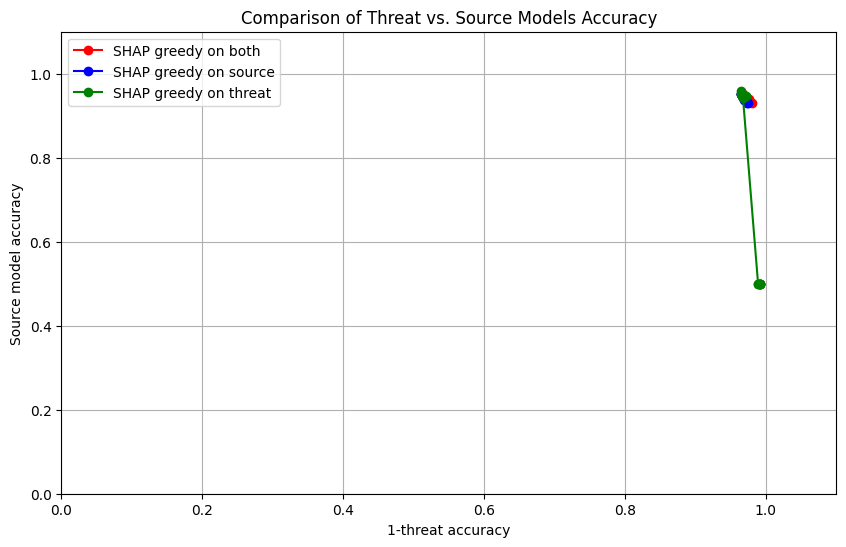

Training set size: 0.1
0.00041534988926645347
Percentile of features to keep: 3; Number of features to keep: 12; Ratio Threshold: 0.00041534988926645347
-0.02380612878854714
Percentile of features to keep: 3; Number of features to keep: 3; Ratio Threshold: -0.02380612878854714


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 3; Number of features to keep: 2; Ratio Threshold: 0.6567109228086793
0.00041534988926645347
Percentile of features to keep: 5; Number of features to keep: 12; Ratio Threshold: 0.00041534988926645347
-0.021299834809270248
Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: -0.021299834809270248


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 5; Number of features to keep: 4; Ratio Threshold: 0.7708792114186739
0.00041534988926645347
Percentile of features to keep: 7; Number of features to keep: 12; Ratio Threshold: 0.00041534988926645347
-0.020911897902386036
Percentile of features to keep: 7; Number of features to keep: 6; Ratio Threshold: -0.020911897902386036


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 7; Number of features to keep: 5; Ratio Threshold: 0.8253363249142871


y_pred contains classes not in y_true


0.00041534988926645347
Percentile of features to keep: 9; Number of features to keep: 12; Ratio Threshold: 0.00041534988926645347
-0.01989999095267017
Percentile of features to keep: 9; Number of features to keep: 7; Ratio Threshold: -0.01989999095267017


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 9; Number of features to keep: 6; Ratio Threshold: 0.9085416815489582


y_pred contains classes not in y_true


0.00041534988926645347
Percentile of features to keep: 10; Number of features to keep: 12; Ratio Threshold: 0.00041534988926645347
-0.01887015533415006
Percentile of features to keep: 10; Number of features to keep: 8; Ratio Threshold: -0.01887015533415006


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 10; Number of features to keep: 7; Ratio Threshold: 0.9367187452222104


y_pred contains classes not in y_true


0.0006291307915167944
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: 0.0006291307915167944
-0.00987799888686959
Percentile of features to keep: 20; Number of features to keep: 15; Ratio Threshold: -0.00987799888686959


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 20; Number of features to keep: 13; Ratio Threshold: 1.112133381248103


y_pred contains classes not in y_true


0.0020912482648257746
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: 0.0020912482648257746
-0.005899356817895237
Percentile of features to keep: 30; Number of features to keep: 22; Ratio Threshold: -0.005899356817895237


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 30; Number of features to keep: 19; Ratio Threshold: 1.4217015223051344


y_pred contains classes not in y_true


0.005090744834794304
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: 0.005090744834794304


y_pred contains classes not in y_true


-0.004352546467570622
Percentile of features to keep: 40; Number of features to keep: 30; Ratio Threshold: -0.004352546467570622


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 40; Number of features to keep: 25; Ratio Threshold: 1.751607543862053


y_pred contains classes not in y_true


0.009742679257980705
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: 0.009742679257980705


y_pred contains classes not in y_true


-0.0027596170369291184
Percentile of features to keep: 50; Number of features to keep: 37; Ratio Threshold: -0.0027596170369291184


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 50; Number of features to keep: 31; Ratio Threshold: 1.9448569462346366


y_pred contains classes not in y_true


0.013289892695874501
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: 0.013289892695874501


y_pred contains classes not in y_true


-0.0020204708339264517
Percentile of features to keep: 60; Number of features to keep: 44; Ratio Threshold: -0.0020204708339264517


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 60; Number of features to keep: 37; Ratio Threshold: 2.516519158661918


y_pred contains classes not in y_true


0.015029096295868778
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: 0.015029096295868778


y_pred contains classes not in y_true


-0.0012053799645967483
Percentile of features to keep: 70; Number of features to keep: 52; Ratio Threshold: -0.0012053799645967483


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 70; Number of features to keep: 43; Ratio Threshold: 3.360998662030844


y_pred contains classes not in y_true


0.018346504419946345
Percentile of features to keep: 80; Number of features to keep: 59; Ratio Threshold: 0.018346504419946345


y_pred contains classes not in y_true


8.584439157501617e-05
Percentile of features to keep: 80; Number of features to keep: 74; Ratio Threshold: 8.584439157501617e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 80; Number of features to keep: 49; Ratio Threshold: 6.137241265142295


y_pred contains classes not in y_true


0.0264679876946799
Percentile of features to keep: 90; Number of features to keep: 66; Ratio Threshold: 0.0264679876946799


y_pred contains classes not in y_true


8.584439157501617e-05
Percentile of features to keep: 90; Number of features to keep: 74; Ratio Threshold: 8.584439157501617e-05


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 90; Number of features to keep: 55; Ratio Threshold: 9.85642036694178


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true


inf
Percentile of features to keep: 100; Number of features to keep: 74; Ratio Threshold: inf


y_pred contains classes not in y_true
divide by zero encountered in divide
invalid value encountered in divide
divide by zero encountered in divide
invalid value encountered in divide


Percentile of features to keep: 100; Number of features to keep: 57; Ratio Threshold: inf


y_pred contains classes not in y_true


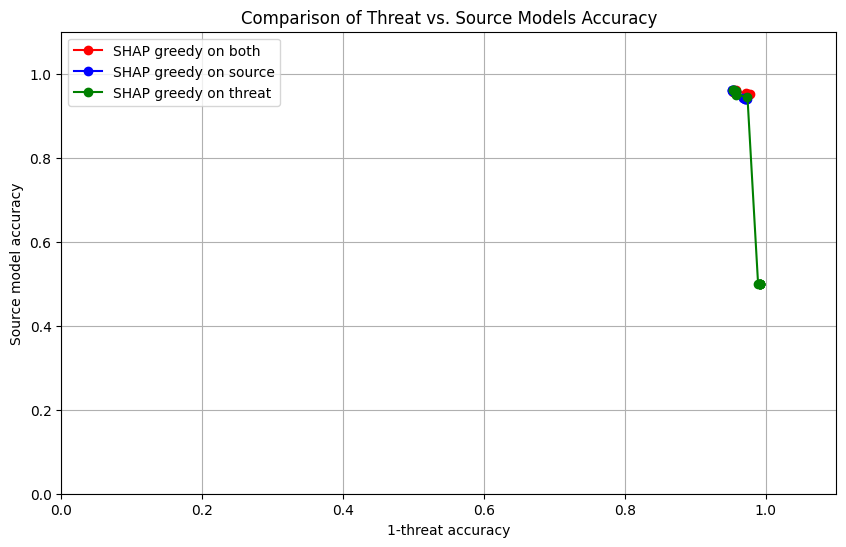

Training set size: 0.3


In [ ]:
from sklearn.model_selection import train_test_split

df_Y_train_og = pd.read_csv("Y_train_by_subnet.csv")
df_X_train_og = pd.read_csv("X_train_by_subnet.csv")

for train_size in [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 0.5, 0.7, 0.9]:
    print('Training set size:', train_size)
    df_X_train, _, df_Y_train, _ = train_test_split(df_X_train_og, df_Y_train_og, train_size=train_size, random_state=42)
    shap_feature_selection(df_X_train, df_Y_train, custom_text=f'train size:{train_size}')


In [33]:
def plot_multiple_accuracy_features(score_lists, legend_names):
    plt.figure(figsize=(6, 4))
    
    # Define a list of colors for different plots
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'lime', 'navy']
    markers = ['o', '^', 's', 'd', '*', 'p', 'x', 'D', 'h', '+']
    marker_size = 10

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        # releff_list = [
        #     compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
        #     for row in score_list
        # ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        marker = markers[i % len(markers)]
        plt.scatter(score_list[:, 0], score_list[:, 1], color=color, marker=marker, label=legend_name, s=marker_size)
    
    plt.title('Comparison of Accuracy vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Prediction Accuracy After Feature Minimization')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    # bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    # plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
    #          bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='lower center', fontsize=8, ncol=3)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('serv_rec_full_nprint_10pkts-accuracy-features.pdf')
    plt.show()


def plot_multiple_ident_features(score_lists, legend_names):
    plt.figure(figsize=(6, 4))
    
    # Define a list of colors for different plots
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'lime', 'navy']
    markers = ['o', '^', 's', 'd', '*', 'p', 'x', 'D', 'h', '+']
    marker_size = 10

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        # releff_list = [
        #     compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
        #     for row in score_list
        # ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        marker = markers[i % len(markers)]
        plt.scatter(score_list[:, 0], score_list[:, 2], color=color, marker=marker, label=legend_name, s=marker_size)
    
    plt.title('Comparison of Identifiability vs. Number of Features')
    plt.xlabel('Number of Features')
    plt.ylabel('Identifiability After Feature Minimization')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    # bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    # plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
    #          bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='lower center', fontsize=8, ncol=3)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('serv_rec_full_nprint_10pkts-ident-features.pdf')
    plt.show()


In [34]:
def plot_multiple_releff_accuracies(score_lists, legend_names):
    plt.figure(figsize=(6, 4))
    
    # Define a list of colors for different plots
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'lime', 'navy']
    markers = ['o', '^', 's', 'd', '*', 'p', 'x', 'D', 'h', '+']
    marker_size = 10

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        releff_list = [
            compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
            for row in score_list
        ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        marker = markers[i % len(markers)]
        plt.scatter(score_list[:, 1], releff_list, color=color, marker=marker, label=legend_name, s=marker_size)
    
    plt.title('Comparison of Relative Effectiveness vs. Accuracy')
    plt.xlabel('Prediction Accuracy After Feature Minimization')
    plt.ylabel('Relative Effectiveness')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    # bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    # plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
    #          bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='upper left', fontsize=8, ncol=2)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('serv_rec_full_nprint_10pkts-releff-accuracy.pdf')
    plt.show()

def plot_multiple_releff_ident(score_lists, legend_names):
    plt.figure(figsize=(6, 4))
    
    # Define a list of colors for different plots
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'orange', 'lime', 'navy']
    markers = ['o', '^', 's', 'd', '*', 'p', 'x', 'D', 'h', '+']
    marker_size = 10

    for i, (score_list, legend_name) in enumerate(zip(score_lists, legend_names)):
        releff_list = [
            compute_relative_effectiveness(row[2], row[1], base_ident, base_acc) 
            for row in score_list
        ]
        color = colors[i % len(colors)]  # Cycle through colors if there are more score_lists than colors
        marker = markers[i % len(markers)]
        plt.scatter(score_list[:, 2], releff_list, color=color, marker=marker, label=legend_name, s=marker_size)
    
    plt.title('Comparison of Relative Effectiveness vs. Identifiability')
    plt.xlabel('Identifiability After Feature Minimization')
    plt.ylabel('Relative Effectiveness')
#     plt.ylim(0, 1.1)
#     plt.xlim(0, 1.1)

    # Adding the arrow annotation
    # bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=2, alpha=0.5)
    # plt.text(0.1, 0.1, "Better", ha="center", va="center", rotation=45, size=15,
    #          bbox=bbox_props, transform=plt.gca().transAxes)

    # Adding a legend
    plt.legend(loc='upper left', fontsize=8, ncol=2)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.savefig('serv_rec_full_nprint_10pkts-releff-identifiability.pdf')
    plt.show()


/tmp/ipykernel_1425904/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)
/tmp/ipykernel_1425904/1236790252.py:6: RuntimeWarning: divide by zero encountered in log
  return np.log(numerator / denominator)


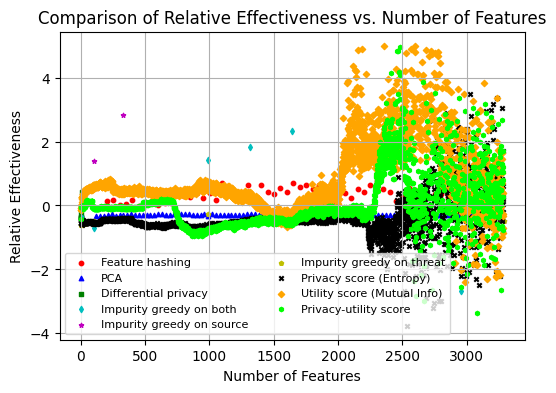

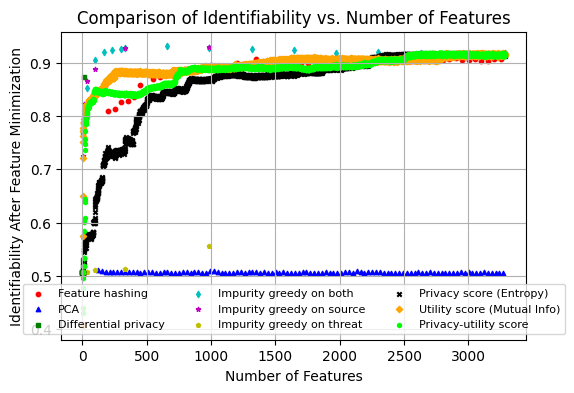

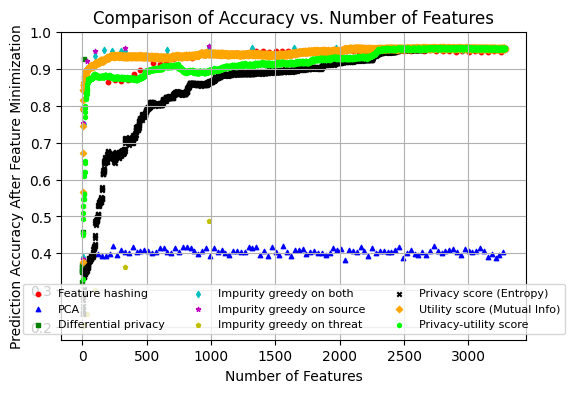

/tmp/ipykernel_1425904/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)
/tmp/ipykernel_1425904/1236790252.py:6: RuntimeWarning: divide by zero encountered in log
  return np.log(numerator / denominator)


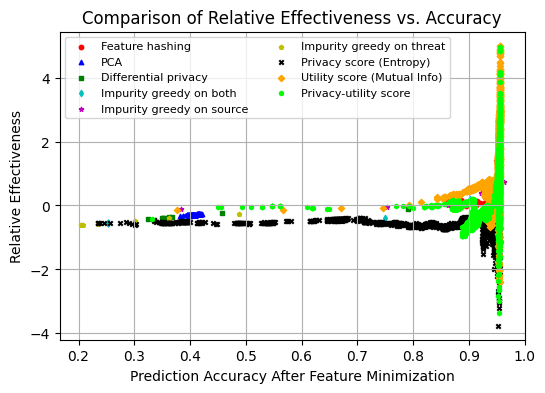

/tmp/ipykernel_1425904/1236790252.py:6: RuntimeWarning: invalid value encountered in log
  return np.log(numerator / denominator)
/tmp/ipykernel_1425904/1236790252.py:6: RuntimeWarning: divide by zero encountered in log
  return np.log(numerator / denominator)


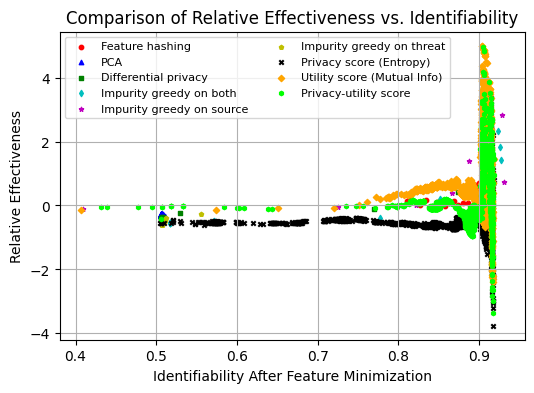

In [35]:
score_list_fh = np.loadtxt(f'serv_rec_full_nprint_10pkts-feature_hashing.csv', delimiter=",")
score_list_pca = np.loadtxt(f'serv_rec_full_nprint_10pkts-pca_reduction.csv', delimiter=",")
score_list_dp = np.loadtxt(f'serv_rec_full_nprint_10pkts-differential_privacy.csv', delimiter=",")
score_list_privacy = np.loadtxt(f'serv_rec_full_nprint_10pkts-privacy-score.csv', delimiter=",")
score_list_utility = np.loadtxt(f'serv_rec_full_nprint_10pkts-utility-score.csv', delimiter=",")
score_list_privacy_utility = np.loadtxt(f'serv_rec_full_nprint_10pkts-privacy-utility.csv', delimiter=",")

custom_text='train size:1'
score_list_both = np.loadtxt(f'../impurity.score_list_both_random_forest_serv_rec_full_nprint_10pkts.csv', delimiter=",")
score_list_source = np.loadtxt(f'../impurity.score_list_source_random_forest_serv_rec_full_nprint_10pkts.csv', delimiter=",")
score_list_threat = np.loadtxt(f'../impurity.score_list_threat_random_forest_serv_rec_full_nprint_10pkts.csv', delimiter=",")

score_lists = [score_list_fh[4:, :], score_list_pca[4:, :], score_list_dp,
               score_list_both, score_list_source, score_list_threat,
               score_list_privacy, score_list_utility,
               score_list_privacy_utility]
legend_lists = ['Feature hashing', 'PCA', 'Differential privacy',
                'Impurity greedy on both', 'Impurity greedy on source', 'Impurity greedy on threat',
                'Privacy score (Entropy)', 'Utility score (Mutual Info)',
                'Privacy-utility score']
plot_multiple_accuracies(score_lists, legend_lists)
plot_multiple_ident_features(score_lists, legend_lists)
plot_multiple_accuracy_features(score_lists, legend_lists)
plot_multiple_releff_accuracies(score_lists, legend_lists)
plot_multiple_releff_ident(score_lists, legend_lists)

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def plot_absolute_accuracy(score_list, base_accuracy, base_ident, method=''):
    # Extract values
    num_features = score_list[:, 0]
    accuracy = base_accuracy - score_list[:, 1]
    ident_diff = base_ident - score_list[:, 2]
    # y_max = max(max(accuracy), max(ident_diff))
    y_max = 0.6

    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Left y-axis for accuracy
    ax1.set_xlabel('Number of Features')
    ax1.set_ylabel('Accuracy Loss', color='tab:blue')
    ax1.plot(num_features, accuracy, 'o-', color='tab:blue', label='Accuracy')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim(0, y_max)

    # Right y-axis for identification difference
    ax2 = ax1.twinx()
    ax2.set_ylabel('Identifiability Reduction', color='tab:red')
    ax2.plot(num_features, ident_diff, 's-', color='tab:red', label='Identifiability Reduction')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.set_ylim(0, y_max)

    # Title and grid
    plt.title(f'# Features vs. Accuracy Loss & Identifiability Reduction ({method})', fontsize=8)
    fig.tight_layout()
    plt.grid(True)

    # Save and show
    plt.savefig(f'serv_rec_full_nprint_10pkts-{method}.pdf')
    plt.show()



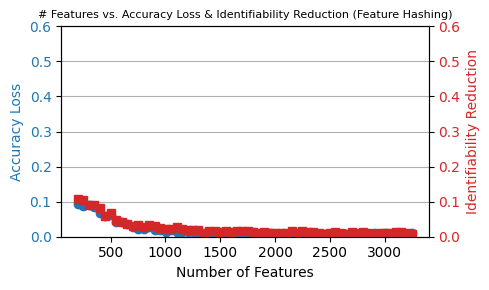

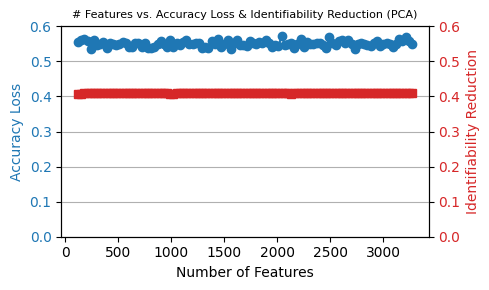

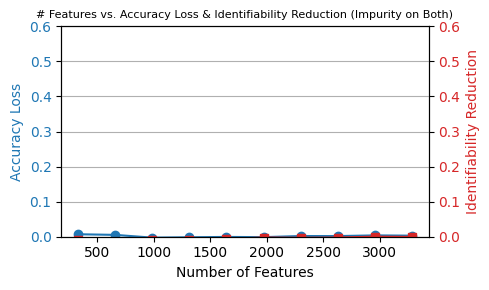

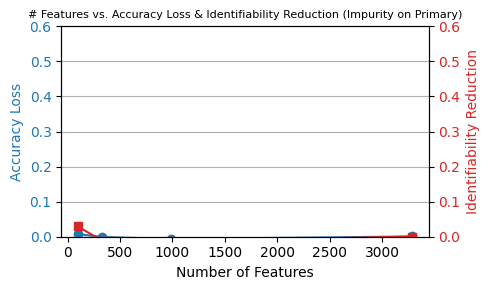

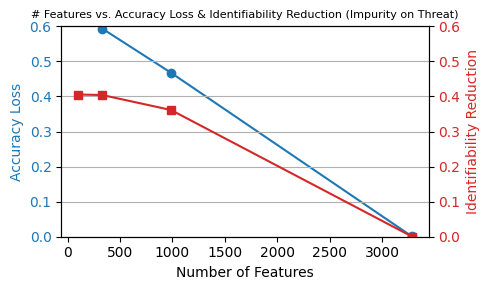

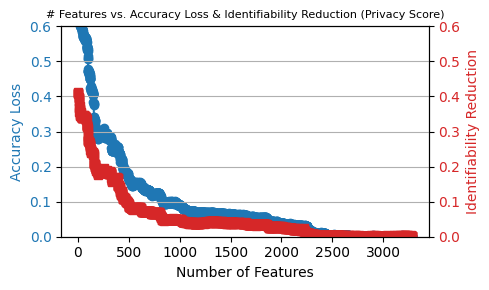

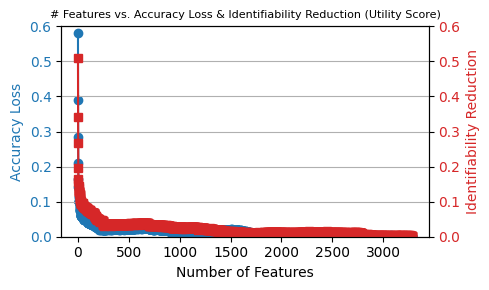

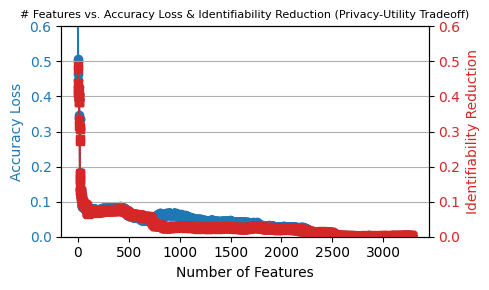

[None, None, None, None, None, None, None, None]

In [49]:
score_list_fh = np.loadtxt(f'serv_rec_full_nprint_10pkts-feature_hashing.csv', delimiter=",")
score_list_pca = np.loadtxt(f'serv_rec_full_nprint_10pkts-pca_reduction.csv', delimiter=",")
score_list_dp = np.loadtxt(f'serv_rec_full_nprint_10pkts-differential_privacy.csv', delimiter=",")
score_list_privacy = np.loadtxt(f'serv_rec_full_nprint_10pkts-privacy-score.csv', delimiter=",")
score_list_utility = np.loadtxt(f'serv_rec_full_nprint_10pkts-utility-score.csv', delimiter=",")
score_list_privacy_utility = np.loadtxt(f'serv_rec_full_nprint_10pkts-privacy-utility.csv', delimiter=",")

custom_text='train size:1'
score_list_impurity_both = np.loadtxt(f'../impurity.score_list_both_random_forest_serv_rec_full_nprint_10pkts.csv', delimiter=",")
score_list_impurity_source = np.loadtxt(f'../impurity.score_list_source_random_forest_serv_rec_full_nprint_10pkts.csv', delimiter=",")
score_list_impurity_threat = np.loadtxt(f'../impurity.score_list_threat_random_forest_serv_rec_full_nprint_10pkts.csv', delimiter=",")

# score_list_both = np.loadtxt(f'shap_{custom_text}.score_list_both.csv', delimiter=",")
# score_list_source = np.loadtxt(f'shap_{custom_text}.score_list_source.csv', delimiter=",")
# score_list_threat = np.loadtxt(f'shap_{custom_text}.score_list_threat.csv', delimiter=",")

score_lists = [score_list_fh[4:, :], score_list_pca[4:, :], #score_list_dp,
               score_list_impurity_both[4:, :], score_list_impurity_source[4:, :], score_list_impurity_threat[4:, :],
               score_list_privacy, score_list_utility, score_list_privacy_utility,]
               #score_list_both, score_list_source, score_list_threat,]

methods = ['Feature Hashing', 'PCA', 'Impurity on Both', 'Impurity on Primary', 'Impurity on Threat',
           'Privacy Score', 'Utility Score', 'Privacy-Utility Tradeoff'] #, 'SHAP on Both', 'SHAP on Primary', 'SHAP on Threat']
[plot_absolute_accuracy(score_list, base_acc, base_ident, method) for score_list, method in zip(score_lists, methods)]
